<a href="https://colab.research.google.com/github/samlim1104/PneumoniaDetectionApp/blob/main/Section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting Started with Streamlit**
<img src="https://images.datacamp.com/image/upload/v1640050215/image27_frqkzv.png" alt="Streamlit" width="250" height="150">

<p><a href="https://docs.streamlit.io">Streamlit</a> is a Python library that contains many useful functions we can use to quickly build websites for data apps!

Unlike traditional web development which often requires an understanding of multiple languages like HTML, CSS, and JavaScript, Streamlit simplifies this process by offering a Python-centric approach. With just a few lines of code, you can quickly build and format a website!</p>

In [1]:
#@title Run this to set up Streamlit!


# -------------------------- #
# INSTALLATION
# -------------------------- #
!pip -q install pyngrok > /dev/null
!pip -q install streamlit > /dev/null
!pip install -q albumentations

# -------------------------- #
# IMPORTS
# -------------------------- #
import tensorflow as tf
from PIL import Image

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import (Activation, MaxPooling2D, Dropout, Flatten, Reshape,
                          Dense, Conv2D, GlobalAveragePooling2D, Input)
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16, VGG19, DenseNet121
from tensorflow.keras.applications import ResNet50

import albumentations as A

# -------------------------- #
# AUGMENTATION FUNCTIONS
# -------------------------- #
def apply_aug(data, transform):
    if len(data.shape) == 3:
        return transform(image=data)['image']
    return np.stack([transform(image=img)['image'] for img in data])

def rotate(data, angle):
    return apply_aug(data, A.Rotate(limit=angle, p=1))

def shear(data, shear_val):
    return apply_aug(data, A.Affine(shear={"x": shear_val, "y": 0}, p=1))

def scale(data, scale_val):
    return apply_aug(data, A.Affine(scale=scale_val, p=1))

def flip_left_right(data, prob): return apply_aug(data, A.HorizontalFlip(p=prob))
def flip_up_down(data, prob): return apply_aug(data, A.VerticalFlip(p=prob))

def remove_color(data, channel):
    new_data = data.copy()
    if len(data.shape) == 3:
        new_data[:, :, channel] = 0
    elif len(data.shape) == 4:
        new_data[:, :, :, channel] = 0
    return new_data

# -------------------------- #
# DATA LOADING & PROCESSING
# -------------------------- #
class pkg:
    @staticmethod
    def get_metadata(metadata_path, splits=['train', 'test']):
        return pd.read_csv(metadata_path).query("split in @splits")

    @staticmethod
    def get_data_split(split_name, flatten, all_data, metadata, shape):
        df = metadata[metadata['split'] == split_name]
        data = all_data[df['index'].values]
        labels = df['class'].values
        return data.reshape([-1, np.prod(shape)]) if flatten else data, labels

    @staticmethod
    def get_field_data(flatten, all_data, metadata, shape):
        data, labels = pkg.get_data_split('field', flatten, all_data, metadata, shape)
        data[:, :, :, 1] = data[:, :, :, 0]
        data[:, :, :, 2] = data[:, :, :, 0]
        rand = random.uniform(-1, 1)
        for i in range(len(data)):
            data[i] = rotate(data[i], rand * 40) if abs(rand) < 0.5 else shear(data[i], rand * 40)
        return data, labels

# -------------------------- #
# HELPER FUNCTIONS
# -------------------------- #
class helpers:
    @staticmethod
    def plot_one_image(data, labels=[], index=None, shape=[64, 64, 3]):
        if data.ndim == 1:
            data = data.reshape(shape)
        elif data.ndim == 2:
            data = data.reshape([-1] + shape)

        img = data if data.ndim == 3 else data[index]
        label = labels if data.ndim == 3 else labels[index]
        print(f"Label: {label}")
        plt.imshow(img)
        plt.show()

    @staticmethod
    def plot_acc(history, ax=None, xlabel='Epoch #'):
        history = pd.DataFrame(history.history)
        history['epoch'] = history.index
        best_epoch = history['val_accuracy'].idxmax()

        if ax is None:
            _, ax = plt.subplots()
        sns.lineplot(data=history, x='epoch', y='accuracy', label='Training', ax=ax)
        sns.lineplot(data=history, x='epoch', y='val_accuracy', label='Validation', ax=ax)
        ax.axhline(0.5, ls='--', color='red', label='Chance')
        ax.axvline(best_epoch, ls='--', color='green', label='Best Epoch')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Accuracy')
        ax.legend()
        plt.show()

    @staticmethod
    def combine_data(data_list, label_list):
        return np.concatenate(data_list, axis=0), np.concatenate(label_list, axis=0)

# -------------------------- #
# MODEL BUILDERS
# -------------------------- #
class models:
    @staticmethod
    def DenseClassifier(hidden_layers, params):
        model = Sequential([Input(params['input_shape']), Flatten(), Dropout(0.5)])
        for size in hidden_layers:
            model.add(Dense(size, activation='relu'))
            model.add(Dropout(0.5))
        model.add(Dense(params['output_neurons'], activation=params['output_activation']))
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(1e-4, momentum=0.95),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def CNNClassifier(n_layers, params):
        model = Sequential([Input(params['input_shape']),
                            Conv2D(32, 3, padding='same', kernel_regularizer=l2(0.01)), Activation('relu'),
                            MaxPooling2D(2)])
        for _ in range(n_layers - 1):
            model.add(Conv2D(64, 3, padding='same', kernel_regularizer=l2(0.01)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.5))
        model.add(Dense(params['output_neurons'], activation=params['output_activation']))
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def TransferClassifier(name, params, trainable=False):
        base_model = {'VGG16': VGG16, 'VGG19': VGG19,
                      'ResNet50': ResNet50, 'DenseNet121': DenseNet121}[name](
            include_top=False, weights='imagenet', input_shape=params['input_shape']
        )
        for layer in base_model.layers:
            layer.trainable = trainable
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(params['output_neurons'], activation=params['output_activation'])
        ])
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(1e-4, momentum=0.9),
                      metrics=['accuracy'])
        return model

# -------------------------- #
# CONFIGURATION
# -------------------------- #
image_shape = (64, 64, 3)
metadata_path = './metadata.csv'
image_data_path = './image_data.npy'
metadata_url = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_url = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'

!wget -q --show-progress "$metadata_url" -O $metadata_path
!wget -q --show-progress "$image_url" -O $image_data_path

_all_data = np.load(image_data_path)
_metadata = pkg.get_metadata(metadata_path, ['train', 'test', 'field'])

# -------------------------- #
# SHORTCUTS
# -------------------------- #
get_metadata = lambda: pkg.get_metadata(metadata_path, ['train', 'test'])
get_train_data = lambda flatten=False: pkg.get_data_split('train', flatten, _all_data, _metadata, image_shape)
get_test_data = lambda flatten=False: pkg.get_data_split('test', flatten, _all_data, _metadata, image_shape)
get_field_data = lambda flatten=False: pkg.get_field_data(flatten, _all_data, _metadata, image_shape)

plot_one_image = lambda data, labels=[], index=None: helpers.plot_one_image(data, labels, index, image_shape)
plot_acc = helpers.plot_acc
combine_data = helpers.combine_data

DenseClassifier = lambda h: models.DenseClassifier(h, nn_params)
CNNClassifier = lambda n: models.CNNClassifier(n, nn_params)
TransferClassifier = lambda name: models.TransferClassifier(name, nn_params)

monitor = ModelCheckpoint('./model.keras', monitor='val_accuracy', save_best_only=True)

# -------------------------- #
# MODEL PARAMS
# -------------------------- #
nn_params = {
    'input_shape': image_shape,
    'output_neurons': 1,
    'loss': 'binary_crossentropy',
    'output_activation': 'sigmoid'
}

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

import os
import sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with HiddenPrints():
    # Installing Streamlit & pyngrok
    !pip -q install streamlit
    !pip -q install pyngrok
    from pyngrok import ngrok
    import streamlit as st
    import pandas as pd
    import numpy as np

def launch_website():
  try:
    if ngrok.get_tunnels():
      ngrok.kill()
    tunnel = ngrok.connect()

    print("Click this link to try your web app:")
    print(tunnel.public_url)

    !streamlit run --server.port 80 app.py >/dev/null # Connect to the URL through Port 80 (>/dev/null hides outputs)

  except KeyboardInterrupt:
    ngrok.kill()



./metadata.csv      100%[===================>]  39.56K  --.-KB/s    in 0.001s  
./image_data.npy    100%[===================>] 131.25M   171MB/s    in 0.8s    
metadata.csv.1      100%[===================>]  39.56K  --.-KB/s    in 0.003s  
image_data.npy.1    100%[===================>] 131.25M   218MB/s    in 0.6s    


Before we start deploying our website, we need to set up a few things. First, we need to set up **tunneling.** Tunneling is a technique that allows you to expose your local server to the public internet. This is especially useful for web applications. We'll use <font color="#4169E1"><b>`pyngrok`</b></font> for this.

<font color=SlateGrey><h4><b>
Use [these](https://drive.google.com/file/d/12zwuOuKh91VSHIHS-6S4ADF4HLC2wKJq/view?usp=sharing) instructions to create a ngrok account and get your authtoken!
</b></h4></font>

<font color=DarkGray><h4><b>
Paste your authtoken below next to `!ngrok authtoken`!
</b></h4></font>

In [4]:
!ngrok authtoken 2YSUGt0YIbAiQhV45Zf0xNqpug1_7ciMAiu7AtqybDZvGwd7Z

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


This authentication token will configure Streamlit to push our local site to the web through ngrok!

## **Part 2. Connecting Our Model**

Since the focus of this session is deployment we'll skip over training the model and just load one that we've already trained :)

Here is a reference on how to save and load sklearn and tensorflow models!

For sklearn:
```python
from joblib import dump, load

# ====== Save model ========
dump(model, 'filename.joblib')

# ====== Load model ========
clf = load('filename.joblib')
```

For tensorflow:
```python
import tensorflow as tf

# ====== Save model ========
model.save("filename.keras")

# ====== Load model ========
tf.keras.models.load_model("filename.keras")
```

Our model today is going to be a tensorflow model! Let's load in the model we created last time. Run the cell below to fetch the location of your CNN model. Use our `load_model()` function from above to load in our Keras file!




In [11]:
from google.colab import drive

# Load the model from Google Drive and save to `model`
drive.mount('/content/gdrive')

file_name = "cnn_model_pneumonia_detection.keras" # Change this if your file is named differently!
cnn_path = "/content/gdrive/MyDrive/" + file_name
model = tf.keras.models.load_model(cnn_path)

# Save a copy of the model for later use with our Streamlit app
!cp {cnn_path} .

# Disconnect Drive
drive.flush_and_unmount()

Mounted at /content/gdrive


In [12]:
# Take a look at the model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,249,988 (16.21 MB)

 Trainable params: 2,124,993 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,124,995 (8.11 MB)

## **Part 3: Building your app**


Fill in the below `app.py` file to load in your model and allow for image uploads! If you're confused about any of the code, feel free to ask your instructor. The [Streamlit cheat sheet](https://docs.streamlit.io/library/cheatsheet) should also be helpful for the Streamlit code, and the previous notebooks should be helpful for the code interacting with your model!

To help you with this block of code, we've taken care of some of the hassle of processing the different formats and sizes of images your app might encounter! Take a look at the `process_image()` function defined in the code cell below to make sure you understand what each step is doing.

In [17]:
#@title Example Instructor Solution
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the CNN model
cnn = tf.keras.models.load_model('cnn_model_pneumonia_detection.keras')

# Create a title
st.title("Medical Imaging")

# Function to process and classify the uploaded image
def process_image(image):
    # Convert the image to RGB mode
    image = image.convert('RGB')

    # Resize the image
    image = image.resize((64, 64))

    # Convert the image to an array and normalize
    img_array = np.array(image).astype('float32')
    img_array = img_array / 255.0

    # Expand dimensions to match the expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Display the image upload widget
uploaded_file = st.file_uploader("Select Image", type=["png", "jpg", "jpeg"])

# Perform prediction and display the result
if uploaded_file is not None:
    # Read the uploaded image
    image = Image.open(uploaded_file)

    # Process and classify the image
    processed_image = process_image(image)
    prediction = cnn.predict(processed_image)
    prediction_label = (prediction > 0.5).astype(int)
    diagnosis = "Pneumonia" if prediction_label else "No Pneumonia"

    # Display the processed image
    st.image(image)

    # Display the predicted diagnosis and confidence score
    confidence = prediction[0][0] if prediction_label else 1 - prediction[0][0]
    st.header("Prediction")
    st.subheader("Diagnosis")
    st.write(diagnosis)
    st.subheader("Confidence Score")
    st.write(f"{confidence:.2%}")

# Display the model architecture
st.subheader("Model Architecture")
cnn.summary(print_fn=st.text)

Overwriting app.py


While running your site, you can try fetching some images from our original dataset below. You can download the image by right-clicking the generated image and <font color="#4169E1"><b>`Save image as...`</b></font> before uploading it to your site!

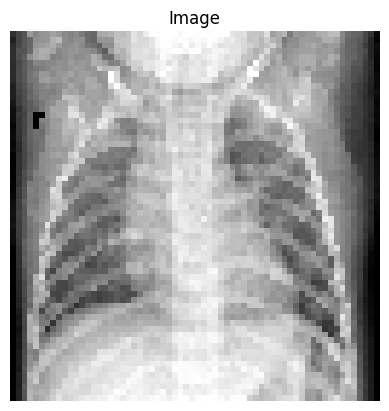

Label: No Pneumonia


In [14]:
#@title Fetch Image { run: "auto", vertical-output: true, display-mode: "form" }

# Load the image data
image_data = np.load('image_data.npy')

# Load the metadata
metadata = pkg.get_metadata(metadata_path, ['train', 'test'])

# Choose an index to download the corresponding image
index = 0 #@param {type:"integer"}

# Get the image from the data array
image = image_data[index]

# Remove the extra channel if it exists
if image.shape[-1] == 4:
    image = image[:, :, :3]

# Create a PIL image object
pil_image = Image.fromarray(np.uint8(image))

# Get the label for the image using the metadata
label = metadata.iloc[index]['class']  # Replace 'class' with the appropriate column name in your metadata
if label == 0:
    label = 'No Pneumonia'
else:
    label = 'Pneumonia'

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title('Image')
plt.show()

# Print the label to the terminal
print(f'Label: {label}')

In [ ]:
# Publish Web App (Run this again whenever you make changes)
launch_website()

Click this link to try your web app:
https://57e62cad4414.ngrok-free.app
2025-07-22 05:25:33.319785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753161933.347937    5464 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753161933.356212    5464 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 05:25:37.802418: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1753161959.030983    5496 service.cc:148] XLA service 0x7e6fd0007d60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1